# CS365 Trending YouTube Video Analysis

# Introduction

This project aims to analyze and predict what US YouTube videos are trending by identifying common characterics of videos from the [YouTube's Trending Videos](https://www.youtube.com/feed/trending) page in the United States. According to an article by [Variety](https://variety.com/2017/digital/news/youtube-2017-top-trending-videos-music-videos-1202631416/) news in 2017, "YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes)" to identify trending videos. YouTube does not mention these factors specifically in their YouTube Help page, but they note that view count and the age of the video are considered among many things.

The information from this project will be useful for content creators, as it will allow them to better tailor their content to the general audience and optimize their marketing strategies. Since the title is one of the first things a viewer will see, we will create a prediction model that will rate the title based on its likelihood to trend.

**Note**: The original dataset is from the kaggle for [Trending Youtube Data Statistics](https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset/data?select=US_youtube_trending_data.csv), downloaded on April 22nd, 2024.

## Importing Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preparation and Transformation

In [3]:
# read trending data and category id files
df = pd.read_csv('US_youtube_trending_data.csv')
df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description'],
      dtype='object')

In [4]:
# drop unnecessary columns and duplicate rows from dataset
df = df.drop(['video_id', 'channelId', 'thumbnail_link', 'comments_disabled', 'ratings_disabled'], axis=1)
df = df.drop_duplicates()

## Time Data
Modify columns to be the proper type and add days_between and avg_daily_views columns. Add dataframes that separate trending videos by year. Change the category id to be the actaul category. Some videos are trending for multiple days, so this results in multiple rows for the same video, which skews the data. This code will ensure that there is only row for each video, that the trending date is the first day it starts trending, and a new column, days trending calculates the number of consecutive days that the video is trending.

In [5]:
# convert columns to their proper type
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
df['trending_date'] = pd.to_datetime(df['trending_date'])

# add two columns: days_between and avg_daily_views
df['days_between'] = (df['trending_date'] - df['publishedAt']).dt.days.astype(int) + 1

# make year column and dataframes for each year
df['trending_year'] = df['trending_date'].dt.year
# convert datetimes columns to dates
df['publishedAt'] = df['publishedAt'].dt.date
df['trending_date'] = df['trending_date'].dt.date

In [6]:
# convert category id column to category titles
category_dict = { 1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports',
    18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs',
    23: 'Comedy',24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education',
    28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation',
    32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign',
    39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'
}

df['category'] = df['categoryId'].map(category_dict)
df.head()


,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,days_between,trending_year,category
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,1,2020,People & Blogs
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare...",1,2020,Gaming
2,I left youtube for a month and THIS is what ha...,2020-08-11,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,I left youtube for a month and this is what ha...,1,2020,Entertainment
3,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,Subscribe to XXL → http://bit.ly/subscribe-xxl...,1,2020,Music
4,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,Transforming The LaBrant Family's empty white ...,1,2020,Howto & Style


In [7]:
def days_trending(df):
    df = df.sort_values(['title', 'trending_date'])     # sort for calculations

    df['group_id'] = (df['days_between'] != 1).cumsum() # create groups where consecutive dates have 'days_between' == 1
    df['days_trending'] = df.groupby(['title', 'group_id'])['trending_date'].transform('count') # calculate days trending

    df = df.drop_duplicates(subset='title', keep='first') # drop duplicate videos and keep first occurence
    df = df.drop('group_id', axis=1)

    return df

df = days_trending(df.copy())
df = df.sort_index() # sort by index


df['avg_daily_views'] = df['view_count'] / df['days_trending']
df['avg_daily_views'] = df['avg_daily_views'].astype(int)


In [8]:
df.head()

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,days_between,trending_year,category,days_trending,avg_daily_views
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,1,2020,People & Blogs,1,1514614
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare...",1,2020,Gaming,1,2381688
2,I left youtube for a month and THIS is what ha...,2020-08-11,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,I left youtube for a month and this is what ha...,1,2020,Entertainment,1,2038853
3,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,Subscribe to XXL → http://bit.ly/subscribe-xxl...,1,2020,Music,1,496771
4,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,Transforming The LaBrant Family's empty white ...,1,2020,Howto & Style,1,1123889


## Zeros, and Nulls
Some videos have 0 dislikes and likes because the creator has disabled likes, dislikes and/or comments. These values will be replaced by the yearly average. Some creators chose not to have anything in their description. Since this is not a numerical value, we will leave it.

In [9]:
years = [2020, 2021, 2022, 2023, 2024]
counts_list = []

for year in years:
    year_counts = {'Year': year}
    # count the number of null or zero values for the current feature and year
    for feature in df.columns:
        if feature in ['view_count', 'likes', 'dislikes', 'comment_count']:
            year_counts[feature] = ((df['trending_year'] == year) & (df[feature].isnull() | (df[feature] == 0))).sum()
        elif feature == 'days_between':
            year_counts[feature] = ((df['trending_year'] == year) & (df[feature].isnull())).sum()
        else:
            year_counts[feature] = ((df['trending_year'] == year) & (df[feature].isnull())).sum()
    counts_list.append(year_counts)

# create dataframe with null counts
df_null_counts = pd.DataFrame(counts_list)
df_null_counts.set_index('Year', inplace=True)
df_null_counts['videos'] = [df['trending_year'].value_counts()[year] for year in years]


df_null_counts.head()

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,days_between,trending_year,category,days_trending,avg_daily_views,videos
Year,,,,,,,,,,,,,,,,,
2020,0,0,0,0,0,0,3,44,44,107,39,0,0,0,0,0,5390
2021,0,0,0,0,0,0,8,92,672,233,376,0,0,0,0,0,13224
2022,0,0,0,0,0,0,5,67,14345,259,421,0,0,0,0,0,14345
2023,0,0,0,0,0,0,1,70,12389,168,89,0,0,0,0,0,12389
2024,0,0,0,0,0,0,2,13,3123,45,17,0,0,0,0,0,3123


In [10]:
# replace missing likes, dislikes and comment counts with yearly averages
# since 2022-2024 have 0 likes/dislikes, they will stay as 0

for year in range(2020, 2025):
    average_like_year = df[df['trending_year'] == year]['likes'].mean().astype(int)
    average_dislike_year = df[df['trending_year'] == year]['dislikes'].mean().astype(int)
    average_comment_count = df[df['trending_year'] == year]['comment_count'].mean().astype(int)
    
    # replace zeros with the average for each year
    df.loc[(df['trending_year'] == year) & (df['likes'] == 0), 'likes'] = average_like_year
    df.loc[(df['trending_year'] == year) & (df['dislikes'] == 0), 'dislikes'] = average_dislike_year
    df.loc[(df['trending_year'] == year) & (df['comment_count'] == 0), 'comment_count'] = average_comment_count

In [11]:
top_daily_views_df = df.sort_values(by='avg_daily_views', ascending=False)
top_daily_views_df.head()

,title,publishedAt,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,days_between,trending_year,category,days_trending,avg_daily_views
265987,Discord Loot Boxes are here.,2024-04-01,Discord,24,2024-04-02,[None],628718636,47460,0,4829,Why would we ever bring Loot Boxes into a chat...,1,2024,Entertainment,1,628718636
234277,"$1 vs $100,000,000 House!",2023-10-14,MrBeast,24,2023-10-26,[None],115990227,4272235,0,126291,I can’t believe how expensive the last house i...,12,2023,Entertainment,1,115990227
252340,"Tank Vs $500,000",2024-01-13,MrBeast,24,2024-01-24,[None],93514903,3769198,0,69507,He spent so much money lolGrow your money with...,11,2024,Entertainment,1,93514903
212189,"Salaar Teaser | Prabhas, Prashanth Neel, Prith...",2023-07-05,Hombale Films,24,2023-07-07,salaar update|salaar teaser|salaar|salaar teas...,91463891,1803963,0,90546,THE MOST VIOLENT MEN... CALLED ONE MAN... THE ...,2,2023,Entertainment,1,91463891
80193,LISA - 'LALISA' M/V,2021-09-10,BLACKPINK,10,2021-09-11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,85890366,5921316,38624,1958529,LISA - LALISA내 뒷모습만 봐도 알잖아어두워질 때 분홍빛이나새하얀 조명이 ...,1,2021,Music,1,85890366


In [12]:
# removed discord loot boxes becuase the view_count was a very extreme outlier (and wrong)
df = df.drop(265987)

## Controversy Rating
A video's controversy depends on the like to dislike ratio. The closer the ratio is to 0.5, the more controversial it is. This could be a potential factor in identifying trending videos, since controversial videos tend to evoke stronger feelings from individual and lead them to interact more (comment, react, share) with the video.

In [13]:
# calculate the like to dislike ratio and normal its difference from 0.5 on a scale from 0 to 1
df['controversy'] = abs(df['likes'] / (df['likes'] + df['dislikes']) - 0.5)
df['controversy'] = 1 - (df['controversy'] / 0.5).clip(0, 1)

In [14]:
column_order = ['title', 'channelTitle', 'publishedAt', 'trending_date', 'days_between','days_trending','categoryId',
                'category', 'view_count', 'avg_daily_views', 'likes', 'dislikes', 'comment_count', 'controversy',
                'tags', 'description', 'trending_year']
df = df[column_order]

## Text Length

In [31]:
df['title_length'] = df['title'].apply(lambda x: len(str(x)))
df['description_length'] = df['description'].apply(lambda x: len(str(x)))
df['num_tags'] = df['tags'].apply(lambda x: len(str(x).split('|')))

# Preliminary Data Analysis

In preliminary data analysis, I created line plots for useful features in analysis. In 2022, there was a significant drop in all user-interaction related categories. We can also see that from 2021 to 2024, the number of dislikes drastically decreases. YouTube disabled public dislike counts in November 2021, and this could have contributed to less users interacting with videos, and the addition of YouTube shorts, which is not included in this dataset. There is a clear cutoff between YouTube videos from 2020-2021 and 2022-2024.

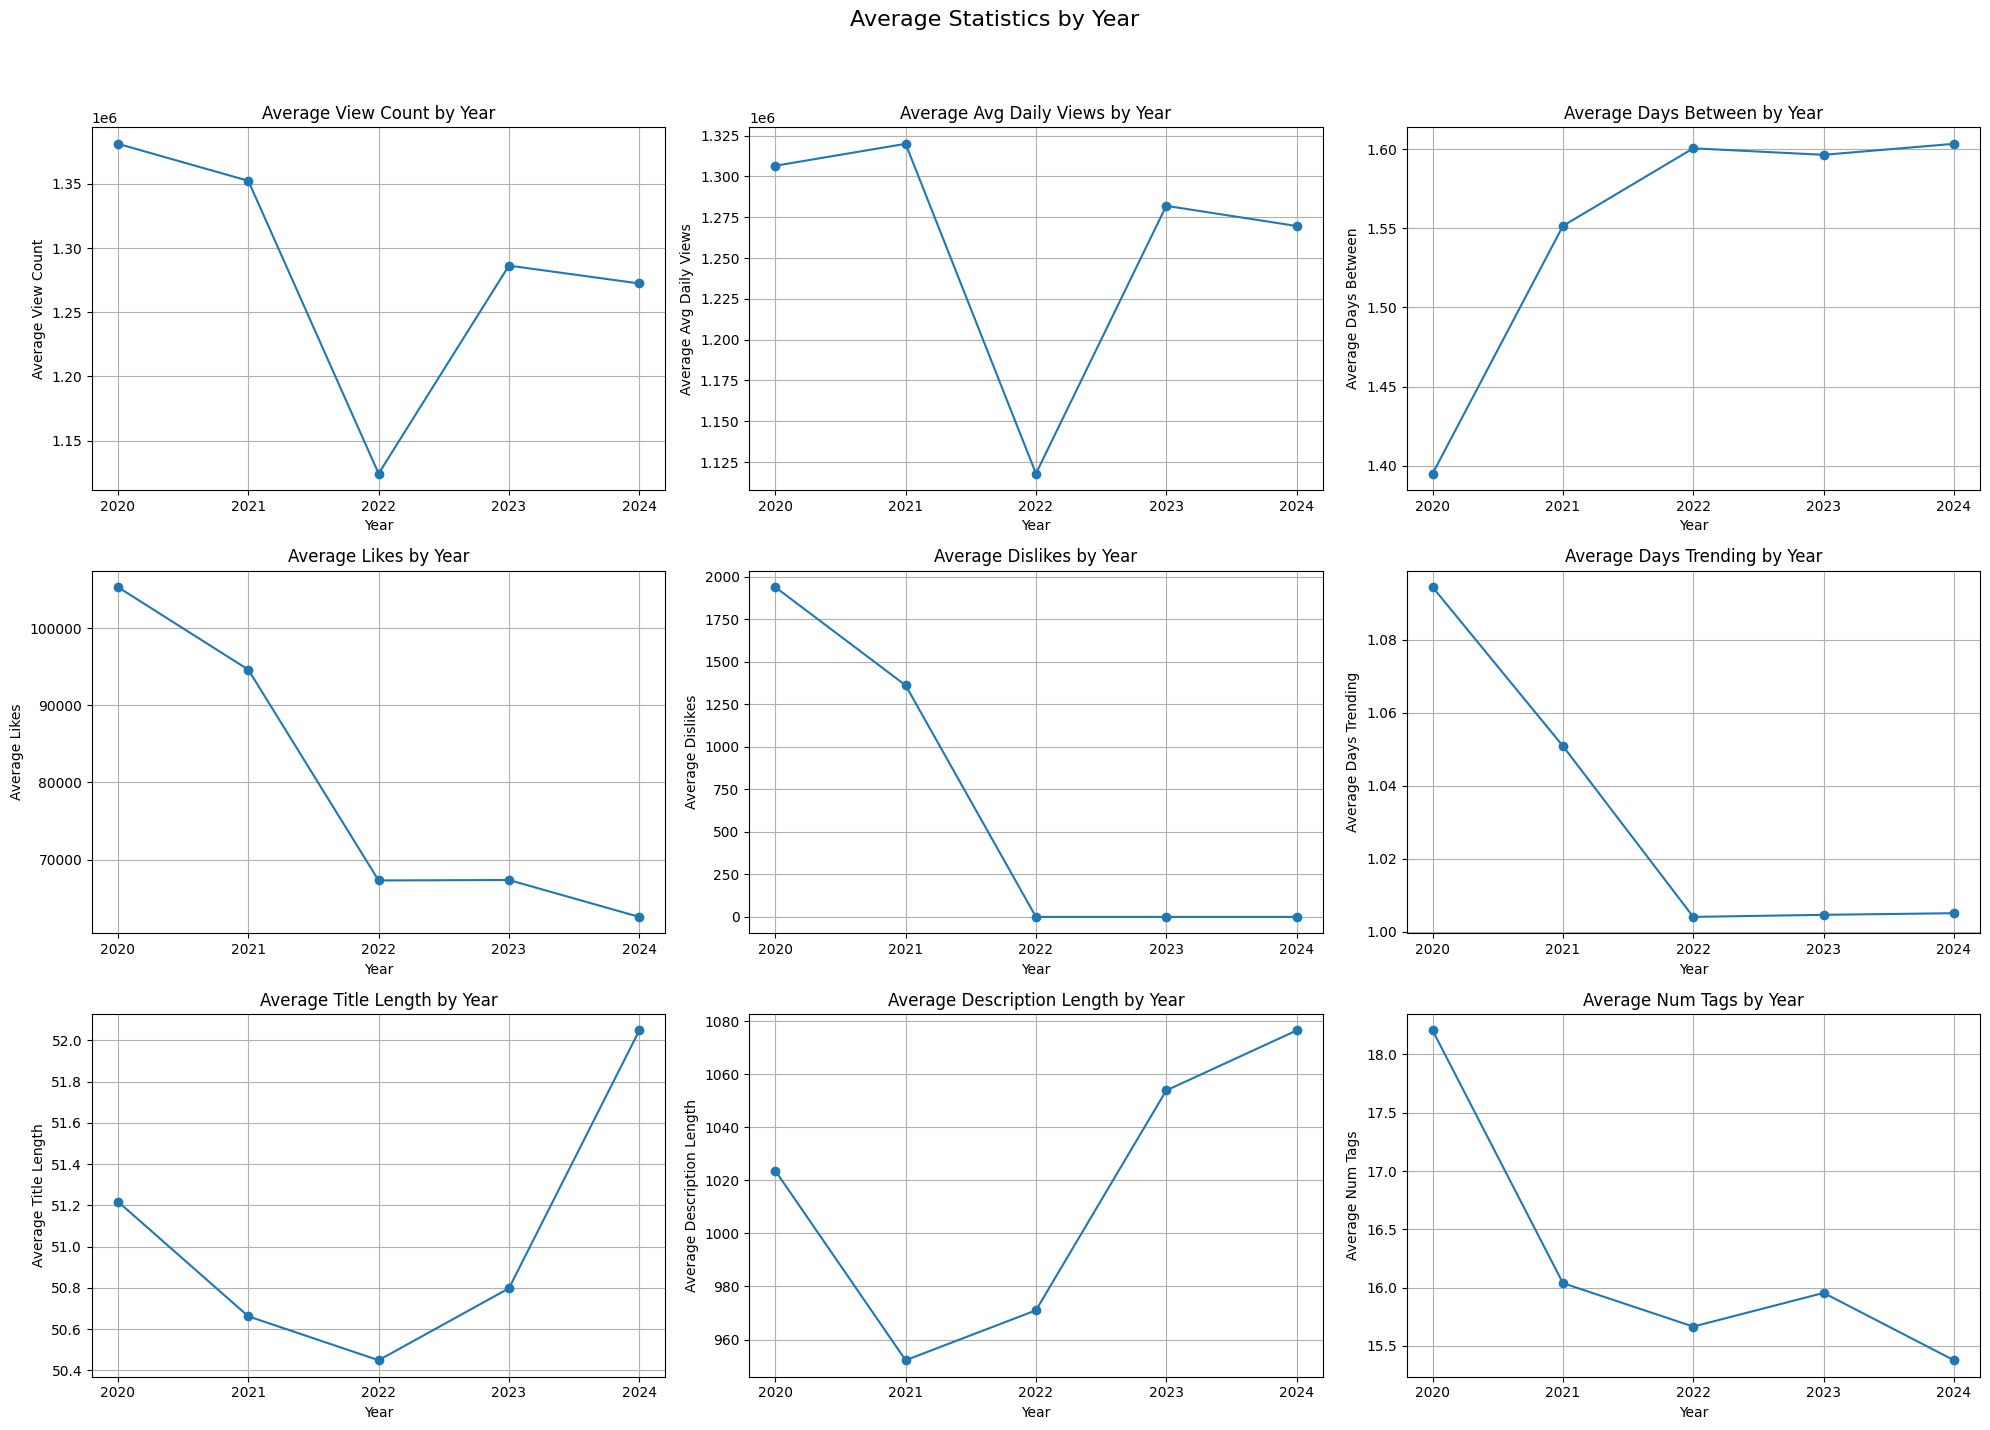

In [32]:
# Calculate statistics for each year
years = [2020, 2021, 2022, 2023, 2024]

# Create subplots with a 3x3 layout
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Define the list of statistics to plot
statistics = ['view_count', 'avg_daily_views', 'days_between', 'likes', 'dislikes', 'days_trending', 
              'title_length', 'description_length', 'num_tags']

for i, stat in enumerate(statistics):
    # Check if the statistic exists in the DataFrame
    if stat in df.columns:
        # Collect data for the statistic
        data = [df[df['trending_year'] == year][stat].mean() for year in years]

        # Plot line plot
        axes[i].plot(years, data, marker='o')

        # Add labels and title
        axes[i].set_title(f'Average {stat.replace("_", " ").title()} by Year')
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel(f'Average {stat.replace("_", " ").title()}')
        axes[i].set_xticks(years)  # Set x-axis ticks as years
        axes[i].grid(True)
    else:
        # If the statistic does not exist, remove the subplot
        fig.delaxes(axes[i])

# Add a title to the entire figure
fig.suptitle('Average Statistics by Year', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the title
plt.show()

## Exploring Non-Commercial Trending Videos
It is also worth noting that many of the videos on the trending list are commercially produced videos (e.g. music videos, movie trailers, tv shows, etc.). Regular content creators may not have the marketing power and fanbase that celebrities or companies have/can generate. Out of the 8509 unique channels that have trending videos, 1934 of them contain "VEVO" which in channel names that post music videos.

In [17]:
print("# of unique channels:", len(df['channelTitle'].unique()))
print("# of VEVO channels:", len(df[df['channelTitle'].str.contains('VEVO')]))
print('% of VEVO channels:', len(df[df['channelTitle'].str.contains('VEVO')])/len(df['channelTitle'].unique())*100)

# of unique channels: 8509
# of VEVO channels: 1934
% of VEVO channels: 22.728875308496885


In [18]:
df.describe()

,days_between,days_trending,categoryId,view_count,avg_daily_views,likes,dislikes,comment_count,controversy,trending_year
count,48470.000000,48470.000000,48470.000000,4.847000e+04,4.847000e+04,4.847000e+04,48470.000000,4.847000e+04,48470.000000,48470.000000
mean,1.563503,1.027130,18.784857,1.266070e+06,1.245743e+06,7.869000e+04,587.494677,6.470941e+03,0.021680,2021.889189
std,1.001598,0.163098,6.696355,3.003358e+06,2.947401e+06,2.222689e+05,3522.924549,3.689967e+04,0.064799,1.103916
min,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.700000e+01,0.000000,1.000000e+00,0.000000,2020.000000
25%,1.000000,1.000000,17.000000,3.167162e+05,3.121705e+05,1.373900e+04,0.000000,1.057000e+03,0.000000,2021.000000
50%,1.000000,1.000000,20.000000,5.784960e+05,5.694740e+05,2.885500e+04,0.000000,2.201000e+03,0.000000,2022.000000
75%,2.000000,1.000000,24.000000,1.207934e+06,1.189058e+06,6.697600e+04,343.000000,4.875000e+03,0.021157,2023.000000
max,30.000000,3.000000,29.000000,1.159902e+08,1.159902e+08,7.114337e+06,405329.000000,3.400291e+06,0.999861,2024.000000


In [19]:
# df_elim = remove all rows with channelTitle containinig "VEVO" and "Entertainment"
df_elim = df[~df['channelTitle'].str.contains('VEVO|Entertainment')]

In [20]:
# create two dataframes to separate pre and post dislike view disable
df_pre = df[(df['trending_year'] >= 2020) & (df['trending_year'] <= 2021)]
df_post = df[(df['trending_year'] >= 2022) & (df['trending_year'] <= 2024)]

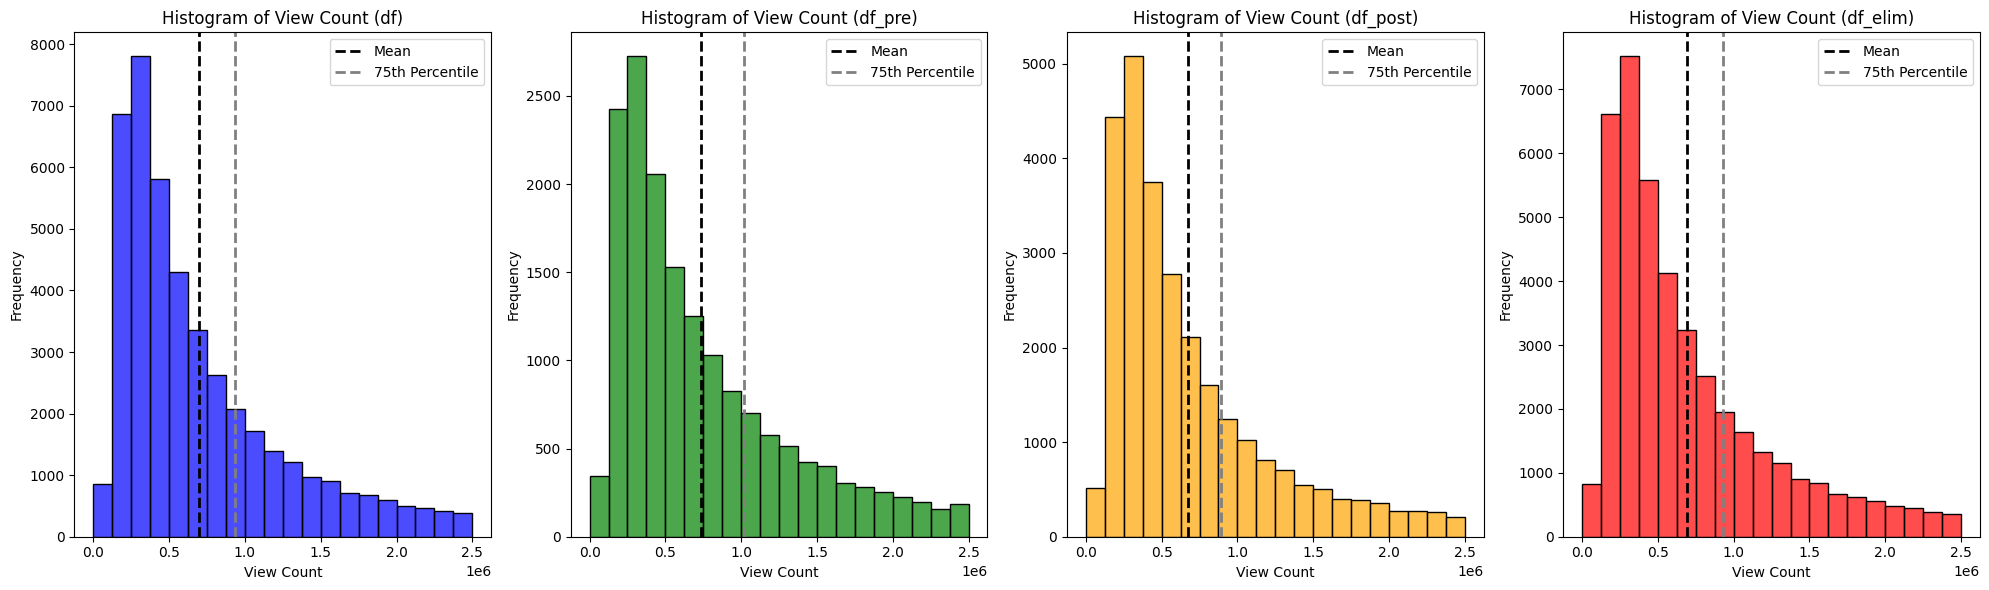

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrames to plot
dataframes = [df, df_pre, df_post, df_elim]
titles = ['Histogram of View Count (df)', 'Histogram of View Count (df_pre)', 
          'Histogram of View Count (df_post)', 'Histogram of View Count (df_elim)']
colors = ['blue', 'green', 'orange', 'red']

# Set up the figure and axes
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, (dataframe, color) in enumerate(zip(dataframes, colors)):
    # Filter view counts under 2.5 million
    filtered_view_counts = dataframe[dataframe['view_count'] < 2500000]['view_count']

    # Plot histogram for filtered view counts
    sns.histplot(filtered_view_counts, bins=20, ax=axes[i], color=color, alpha=0.7, kde=False)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('View Count')
    axes[i].set_ylabel('Frequency')

    # Calculate mean and 75th percentile
    mean_vc = filtered_view_counts.mean()
    percentile_75 = filtered_view_counts.quantile(0.75)

    # Add dashed lines for mean and 75th percentile
    axes[i].axvline(x=mean_vc, color='black', linestyle='dashed', linewidth=2, label='Mean')
    axes[i].axvline(x=percentile_75, color='gray', linestyle='dashed', linewidth=2, label='75th Percentile')

    # Show legend
    axes[i].legend(title=None, loc='upper right')

    # Turn off grid
    axes[i].grid(False)

plt.tight_layout()
plt.show()

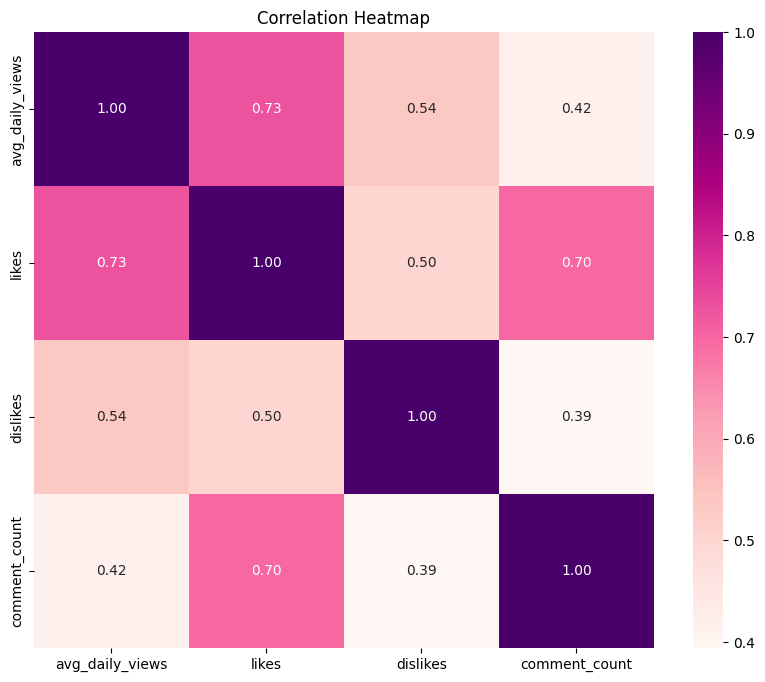

In [21]:
# Select only the columns with integer dtype
int_columns = ['avg_daily_views', 'likes', 'dislikes', 'comment_count']

# Calculate the correlation matrix for the integer columns
corr = df_pre[int_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='RdPu', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [22]:
df_pre.describe()

,days_between,days_trending,categoryId,view_count,avg_daily_views,likes,dislikes,comment_count,controversy,trending_year
count,18614.000000,18614.000000,18614.000000,1.861400e+04,1.861400e+04,1.861400e+04,18614.000000,1.861400e+04,18614.000000,18614.000000
mean,1.506232,1.063501,18.818900,1.360679e+06,1.316085e+06,9.773264e+04,1529.809122,8.991310e+03,0.056454,2020.710433
std,1.159424,0.244967,6.771304,2.840827e+06,2.717127e+06,2.515074e+05,5556.716408,5.315452e+04,0.094715,0.453574
min,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.700000e+01,6.000000,1.000000e+00,0.000488,2020.000000
25%,1.000000,1.000000,17.000000,3.336302e+05,3.217230e+05,1.575475e+04,248.000000,1.295250e+03,0.016464,2020.000000
50%,1.000000,1.000000,20.000000,6.437145e+05,6.203510e+05,3.576100e+04,557.000000,2.864000e+03,0.029359,2021.000000
75%,2.000000,1.000000,24.000000,1.370955e+06,1.330112e+06,8.875825e+04,1296.000000,6.941000e+03,0.056805,2021.000000
max,28.000000,3.000000,29.000000,8.589037e+07,8.589037e+07,7.110071e+06,405329.000000,3.400291e+06,0.999861,2021.000000


# Natural Language Processing
When a user is choosing which video to watch, they immediately look for an eyecatching thumbnail and interesting title. Engaging titles that elicit more positive emotions in viewers may be more interesting and lead to more views. Tags and descriptions also contribute to view count via SEO Optimization. We can also create a relevancy score that assesses the relevancy between the title, description and tag.

In [23]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import words

## Sentiment Analysis

In [24]:
nltk.download('punkt')
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer() # initialize sentiment intensity analyzer

def analyze_sentiment(text):
    tokens = nltk.word_tokenize(text)
    sentiment_score = sia.polarity_scores(text)['compound']
    return sentiment_score

[nltk_data] Downloading package punkt to /Users/briannali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/briannali/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [25]:
df['title_sentiment'] = df['title'].apply(analyze_sentiment)

## TFIDF Similarity

In [46]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove non-alphanumeric characters and extra whitespaces
    text = text.lower() # convert to lowercase
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/briannali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
def avg_tfidf_similarity(tags, text):
    tags = tags.split('|')  # Split tags by '|'
    tags = [tag for tag in tags if tag.strip()]  # Remove empty or whitespace-only tags
    text = preprocess_text(text)
    
    # print("Tags:", tags)
    # print("Text:", text)
    
    if not tags or not text:
        return 0  # Return 0 if there are no tags or no text
    
    documents = tags + [text]

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    if tfidf_matrix.shape[0] == 1:
        return 0  # Return 0 if there's only one document
    
    cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])

    return cosine_similarities.mean()  # Return the average similarity

In [36]:
df['title_tag_similarity'] = df.apply(lambda row: avg_tfidf_similarity(row['tags'], row['title']), axis=1)

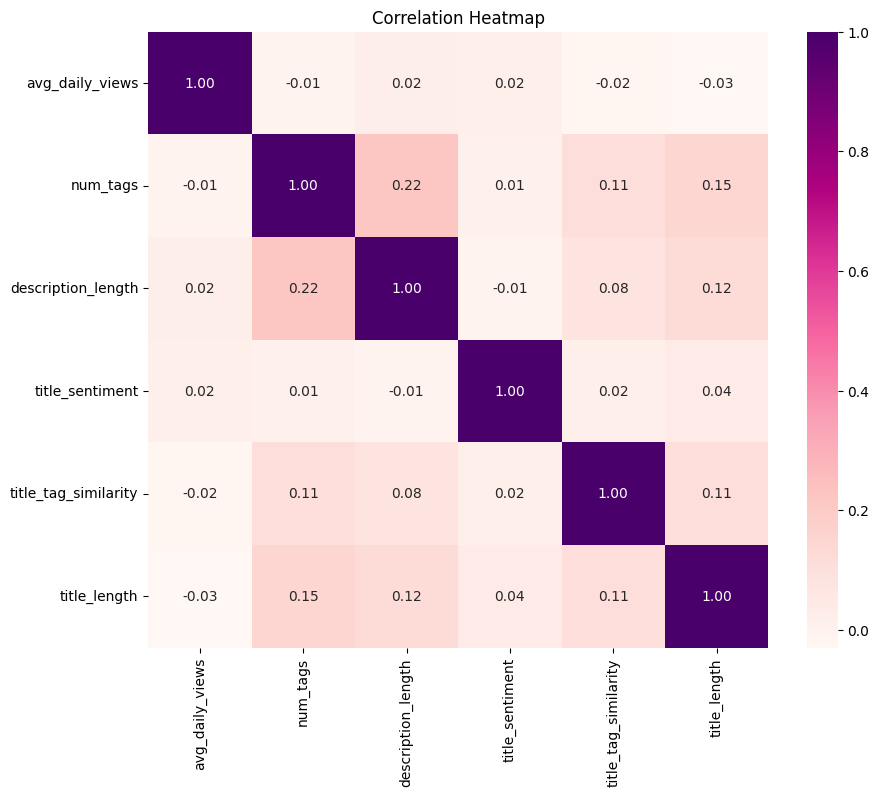

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the columns for the correlation heatmap
selected_columns = ['avg_daily_views','num_tags', 'description_length', 'title_sentiment', 'title_tag_similarity', 'title_length']

# Calculate the correlation matrix for the selected columns
corr_selected = df[selected_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_selected, annot=True, cmap='RdPu', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


# Regression Model

In [66]:
# Select only numeric (float) columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix for numeric columns
corr_numeric = df[numeric_columns].corr()

view_count_corr = corr_numeric['avg_daily_views']

# Sort correlations with view count (avg_daily_views) in descending order
view_count_corr_sorted = view_count_corr.sort_values(ascending=False)

# Print the correlations with view count in descending order
print("Correlations with view count (avg_daily_views) - Descending order:")
print(view_count_corr_sorted)

Correlations with view count (avg_daily_views) - Descending order:
avg_daily_views         1.000000
view_count              0.992969
likes                   0.744799
comment_count           0.390087
dislikes                0.303945
days_between            0.075673
description_length      0.023747
title_sentiment         0.017614
controversy            -0.001277
num_tags               -0.008153
title_tag_similarity   -0.021922
days_trending          -0.028021
categoryId             -0.028879
title_length           -0.030057
Name: avg_daily_views, dtype: float64


## Linear Regression

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Select features and target variable
features = ['likes', 'dislikes', 'comment_count', 'title_sentiment', 'title_tag_similarity', 'title_length']
target = 'avg_daily_views'

# Split the data into features (X) and target variable (y)
X = df[features]
y = df[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 679808.981085136
Mean Squared Error: 4569947215576.176
R-squared: 0.6000694418835455


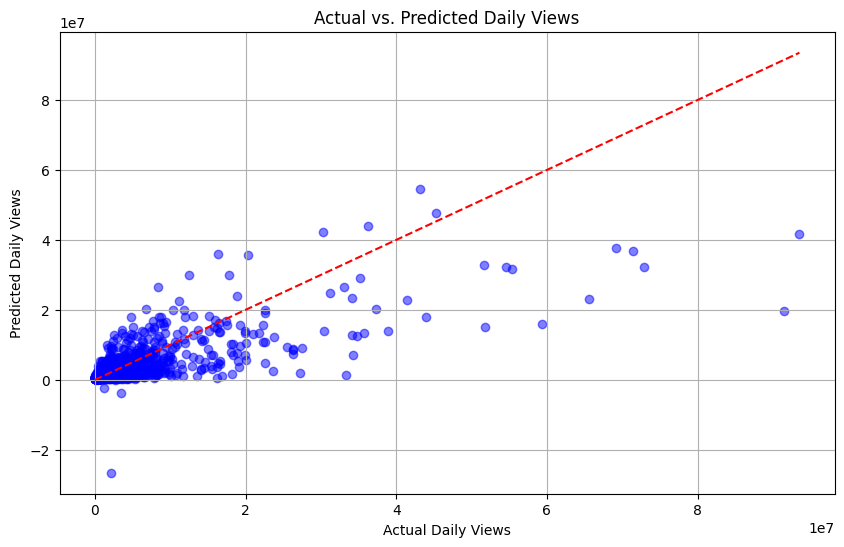

Equation of the line:
y = 2516709.13 * likes + 223336.89 * dislikes + -696346.22 * comment_count + 13801.00 * title_sentiment + -8041.30 * title_tag_similarity + 129482.04 * title_length + 1232642.06


In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Daily Views')
plt.xlabel('Actual Daily Views')
plt.ylabel('Predicted Daily Views')
plt.grid(True)
plt.show()

# Retrieve coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Construct the equation
equation = "y = "
for i in range(len(features)):
    equation += f"{coefficients[i]:.2f} * {features[i]} + "
equation += f"{intercept:.2f}"

print("Equation of the line:")
print(equation)

## Decision Tree

In [77]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 800623.9902001237
Mean Squared Error: 5982158026912.136
R-squared: 0.47648239999591313


In [80]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with more variation
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 5, 7, 10, 15]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the testing set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
Mean Absolute Error: 660463.1950756657
Mean Squared Error: 4331901826320.8022
R-squared: 0.620901548008856


In [85]:
# Create the decision tree model with best parameters
tree_model = DecisionTreeRegressor(max_depth=10, min_samples_split=5)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("Decision Tree Model Metrics:")
print("Mean Absolute Error:", mae_tree)
print("Mean Squared Error:", mse_tree)
print("R-squared:", r2_tree)

Decision Tree Model Metrics:
Mean Absolute Error: 621892.4740788868
Mean Squared Error: 4323433979097.0977
R-squared: 0.6216425961449654


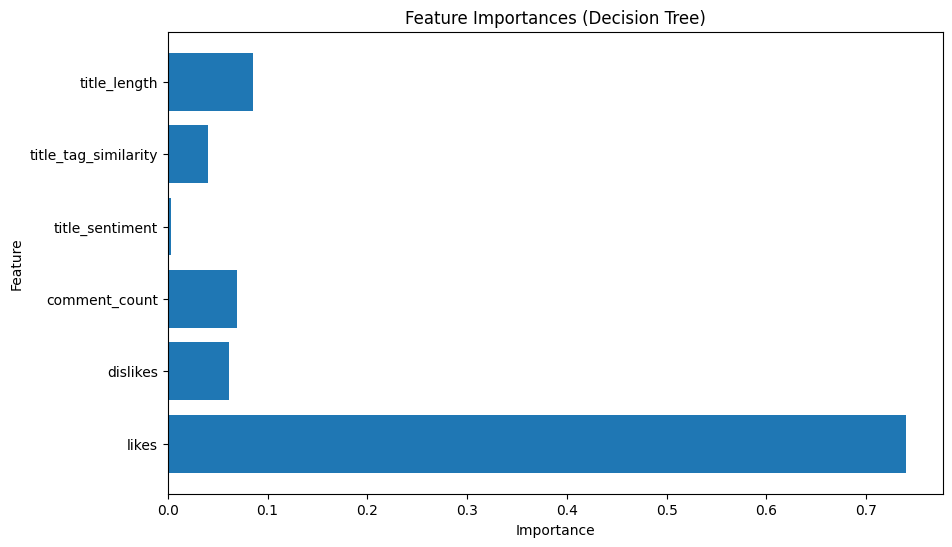

In [88]:
# Get feature importances
feature_importances = tree_model.feature_importances_

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.title('Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Random Forest

In [90]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Mean Absolute Error:", mae_rf)
print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)


Mean Absolute Error: 582374.9202963983
Mean Squared Error: 3248857978876.1973
R-squared: 0.7156821461078435


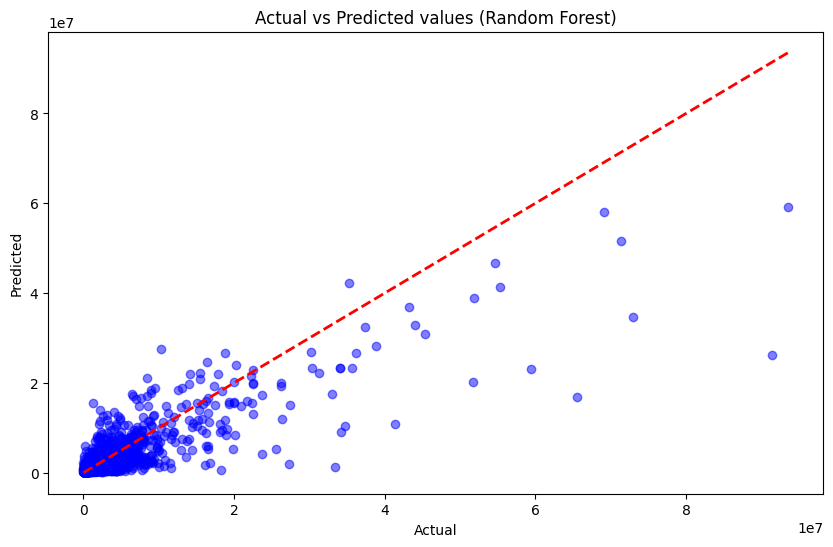

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line in red
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted values (Random Forest)')
plt.show()


In [96]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Create the randomized search object
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist, n_iter=100, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)

# Fit the randomized search to the data
rf_random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_rf = rf_random_search.best_params_
print("Best Parameters:", best_params_rf)


KeyboardInterrupt: 

In [99]:
# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Sort the feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()


Mean Absolute Error: 582374.9202963983
Mean Squared Error: 3248857978876.1973
R-squared: 0.7156821461078435
